# Power Control

This tutorial demonstrates how to allocate transmission power on a per-user
basis in a 3GPP-compliant multicell scenario in the uplink and downlink direction.
- **Uplink**: Implemented by the [open_loop_uplink_power_control](https://nvlabs.github.io/sionna/sys/api/power_control.html#sionna.sys.open_loop_uplink_power_control) function.  
  This follows the open-loop power allocation procedure in 3GPP TS 38.213 [[1]](#references), where
  the transmit power partially compensate for the pathloss by a factor $\alpha\in[0;1]$ while
  targeting a received power of $P_0$ [dBm];
- **Downlink**: Handled by the [downlink_fair_power_control](https://nvlabs.github.io/sionna/sys/api/power_control.html#sionna.sys.downlink_fair_power_control) function.
  This function maximizes a fairness function of the attainable throughput across the
  users on a per-sector basis.


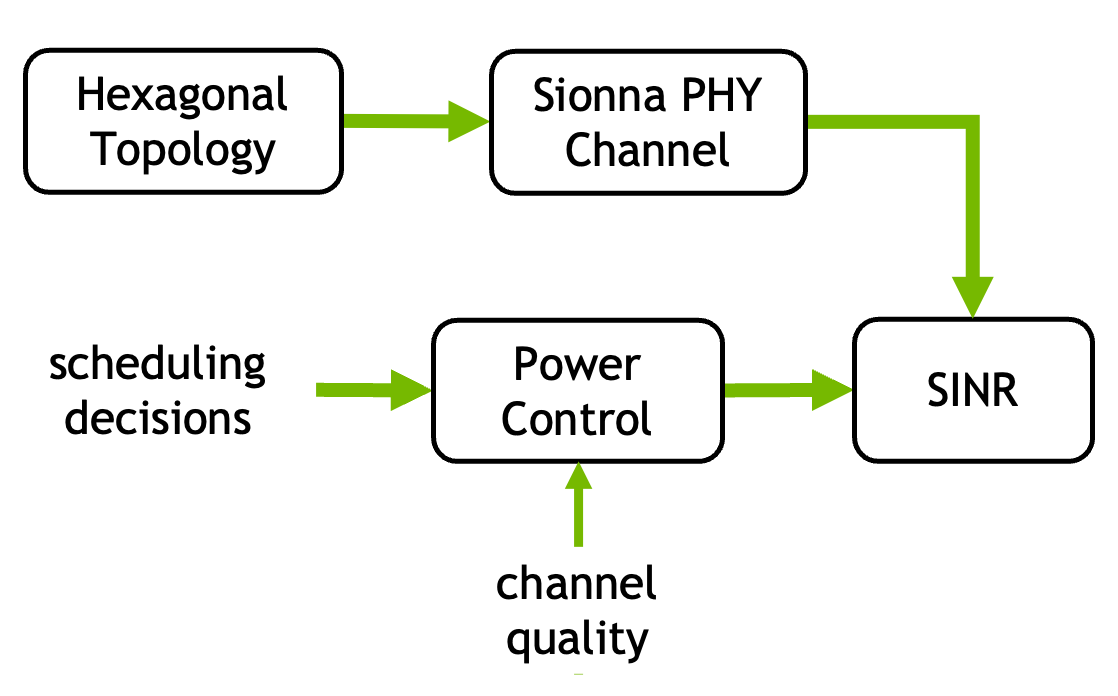

## Imports

We start by importing Sionna and the relevant external libraries:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    if gpu_num!="":
        print(f'\nUsing GPU {gpu_num}\n')
    else:
        print('\nUsing CPU\n')
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna.sys
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
# Additional external libraries
import matplotlib.pyplot as plt
import numpy as np

# Sionna components
from sionna.phy.utils import log2, dbm_to_watt, watt_to_dbm
from sionna.phy.constants import BOLTZMANN_CONSTANT
from sionna.phy.channel import GenerateOFDMChannel
from sionna.phy.ofdm import ResourceGrid, RZFPrecodedChannel, \
    EyePrecodedChannel, LMMSEPostEqualizationSINR
from sionna.phy.channel.tr38901 import UMi, PanelArray
from sionna.phy.mimo import StreamManagement
from sionna.sys import gen_hexgrid_topology, \
    downlink_fair_power_control, open_loop_uplink_power_control
from sionna.sys.utils import spread_across_subcarriers, get_pathloss

# Internal computational precision
sionna.phy.config.precision = 'single'  # 'single' or 'double'

# Set random seed for reproducibility
sionna.phy.config.seed = 45

## Multicell scenario

We first create a multicell 3GPP-compliant scenario on which power control will
be performed in both the uplink and downlink directions.

### Simulation Parameters

We define the main simulation parameters, including the topology settings, OFDM
resource grid, and transmission power for the base stations and user terminal.

In [3]:
# Number of independent scenarios
batch_size = 1

# Number of rings of the spiral hexagonal grid
num_rings = 1

# Number of co-scheduled users per sector
num_ut_per_sector = 5

# OFDM resource grid
num_ofdm_sym = 10
num_subcarriers = 32
subcarrier_spacing = 15e3  # [Hz]
carrier_frequency = 3.5e9  # [Hz]

# Base station and user terminal transmit power
bs_max_power_dbm = 46  # [dBm]
ut_max_power_dbm = 26  # [dBm]

# Convert power to Watts
ut_max_power = dbm_to_watt(ut_max_power_dbm)  # [W]
bs_max_power = dbm_to_watt(bs_max_power_dbm)  # [W]

# Environment temperature
temperature = 294  # [K]
# Noise power per subcarrier
no = BOLTZMANN_CONSTANT * temperature * subcarrier_spacing

# Max distance between user terminal and serving base station
max_bs_ut_dist = 80  # [m]

### Antenna patterns

We create the antenna patterns for base stations and user terminals.

In [4]:
# Create antenna arrays
bs_array = PanelArray(num_rows_per_panel=3,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='VH',
                      antenna_pattern='38.901',
                      carrier_frequency=carrier_frequency)

ut_array = PanelArray(num_rows_per_panel=1,
                      num_cols_per_panel=1,
                      polarization='single',
                      polarization_type='V',
                      antenna_pattern='omni',
                      carrier_frequency=carrier_frequency)

num_ut_ant = ut_array.num_ant
num_bs_ant = bs_array.num_ant

### Topology

Next, we position base stations on a hexagonal grid according to a
3GPP-compliant scenario and randomly distribute users uniformly in each sector.  

For more details on the generation of the topology, see the [Hexagonal Grid Topology notebook](HexagonalGrid.ipynb).

In [5]:
# Generate the spiral hexagonal grid topology
topology = gen_hexgrid_topology(batch_size=batch_size,
                                num_rings=num_rings,
                                num_ut_per_sector=num_ut_per_sector,
                                max_bs_ut_dist=max_bs_ut_dist,
                                scenario='umi')

ut_loc, bs_loc, *_ = topology

# N. users and base stations
num_bs = bs_loc.shape[1]
num_ut = ut_loc.shape[1]

# In the uplink, the user is the transmitter and the base station is the receiver
num_rx, num_tx = num_bs, num_ut

We set and compute the number of streams per user and base station, respectively.

In [6]:
# Set number of streams per user
num_streams_per_ut = num_ut_ant

# Number of streams per base station
num_streams_per_bs = num_streams_per_ut * num_ut_per_sector

assert num_streams_per_ut <= num_ut_ant, \
    "The # of streams per user must not exceed the # of its antennas"

Each receiver is associated with its serving base station.

In [7]:
# For simplicity, each user is associated with its nearest base station

# Uplink
# RX-TX association matrix
rx_tx_association_ul = np.zeros([num_rx, num_tx])
idx_fair = np.array([[i1, i2] for i1 in range(num_rx) for i2 in
                np.arange(i1*num_ut_per_sector, (i1+1)*num_ut_per_sector)])
rx_tx_association_ul[idx_fair[:, 0], idx_fair[:, 1]] = 1

# Instantiate a Stream Management object
stream_management_ul = StreamManagement(rx_tx_association_ul, num_streams_per_ut)

# Downlink
# Receivers and transmitters are swapped wrt uplink
rx_tx_association_dl = rx_tx_association_ul.T
stream_management_dl = StreamManagement(rx_tx_association_dl, num_streams_per_bs)

We create the channel model that will be used to generate the channel impulse responses: 

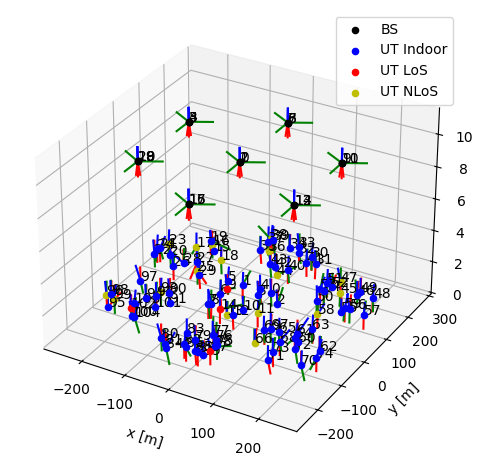

In [8]:
# Create channel model
channel_model = UMi(carrier_frequency=carrier_frequency,
                    o2i_model='low',  # 'low' or 'high'
                    ut_array=ut_array,
                    bs_array=bs_array,
                    direction='uplink',
                    enable_pathloss=True,
                    enable_shadow_fading=True)

channel_model.set_topology(*topology)
channel_model.show_topology()

### Channel

Next, the channel frequency response is computed over the OFDM resource grid.

In [9]:
# Set up the OFDM resource grid
resource_grid = ResourceGrid(num_ofdm_symbols=num_ofdm_sym,
                             fft_size=num_subcarriers,
                             subcarrier_spacing=subcarrier_spacing,
                             num_tx=num_ut_per_sector,
                             num_streams_per_tx=num_streams_per_ut)

# Instantiate the OFDM channel generator
ofdm_channel = GenerateOFDMChannel(channel_model, resource_grid)

# Generate the OFDM channel matrix in the uplink
# [batch_size, num_rx=num_bs, num_rx_ant, num_tx=num_ut, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq_ul = ofdm_channel(batch_size)

# [batch_size, num_rx=num_ut, num_rx_ant, num_tx=num_bs, num_tx_ant, num_ofdm_symbols, num_subcarriers]
h_freq_dl = tf.transpose(h_freq_ul, [0, 3, 4, 1, 2, 5, 6])

We conclude this section by scheduling users for transmission across the
resource grid.  
Note that only one slot is simulated. For more realistic simulations, a
scheduler should be used. This is explained in more details in the [Proportional
Fairness Scheduler notebook](https://nvlabs.github.io/sionna/sys/tutorials/Scheduling.html).

In [10]:
# For simplicity, all users are allocated simultaneously on all resources
is_scheduled = tf.fill([batch_size,
                        num_bs,
                        num_ofdm_sym,
                        num_subcarriers,
                        num_ut_per_sector,
                        num_streams_per_ut],
                       True)

num_allocated_subcarriers = tf.fill([batch_size,
                                     num_bs,
                                     num_ofdm_sym,
                                     num_ut_per_sector],
                                     num_subcarriers)

## Uplink power control

According to the open-loop power control procedure defined in 3GPP TS 38.213
[[1]](#references), the transmit power allocated to a user compensates the pathloss $PL$ from the
serving base station by a factor
$\alpha\in[0;1]$ while targeting a received power $P_0$ [dBm]:

$P^{\mathrm{UL}} = \min \{ P_0 + \alpha PL + 10 \log_{10}(\mathrm{\#PRB}), P^{\mathrm{max}}_{\mathrm{ut}}\} \quad \mathrm{[dBm]}$

where $P^{\mathrm{max}}_{\mathrm{ut}}$ [dBm] is the maximum transmit power for the terminal
and $\mathrm{\#PRB}$ is the number of physical resource blocks allocated to the user. 

As a first step, we compute the pathloss for each user:

In [11]:
_, pathloss_serving_cell = get_pathloss(
        h_freq_ul,
        rx_tx_association=tf.cast(rx_tx_association_ul, dtype=tf.int32))

def group_by_bs(tensor):
    tensor = tf.reshape(
        tensor, [batch_size, num_bs, num_ut_per_sector, num_ofdm_sym])
    # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
    return tf.transpose(tensor, [0, 1, 3, 2])

# Group by base station
# [batch_size, num_bs, num_ut_per_sector, num_ofdm_sym]
pathloss_serving_cell = group_by_bs(pathloss_serving_cell)

The function [open_loop_uplink_power_control](../api/power_control.html#sionna.sys.open_loop_uplink_power_control) allocates the user power according
to the procedure described above.  
We wrap it into an XLA-compiled function that applies power control and computes
the corresponding SINR.

In [12]:
@tf.function(jit_compile=True)
def get_sinr_uplink(h_freq,
                    pathloss_serving_cell,
                    alpha,
                    p0_dbm,
                    ut_max_power_dbm,
                    num_allocated_subcarriers,
                    is_scheduled):
    """ Compute the uplink SINR """

    # Per-user uplink transmit power
    # [batch_size, num_bs, num_ofdm_sym, num_ut_per_sector]
    ul_power_per_ut = open_loop_uplink_power_control(
        pathloss_serving_cell,
        num_allocated_subcarriers,
        alpha=alpha,
        p0_dbm=p0_dbm,
        ut_max_power_dbm=ut_max_power_dbm)

    # Spread power uniformly across subcarriers
    # [batch_size, num_bs, num_ut_per_sector, num_streams_per_ut, num_ofdm_sym,
    #  num_subcarriers]
    ul_power = spread_across_subcarriers(
        ul_power_per_ut,
        is_scheduled,
        num_tx=num_ut_per_sector)

    ul_power = tf.reshape(ul_power,
                          [batch_size, num_ut, num_streams_per_ut,
                           num_ofdm_sym, num_subcarriers])

    # Compute SINR
    precoded_channel = EyePrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management_ul)
    h_eff = precoded_channel(h_freq, tx_power=ul_power)
    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management_ul)
    # [batch_size, num_ofdm_symbols, num_effective_subcarriers, num_rx, num_streams_per_rx]
    sinr = lmmse_posteq_sinr(h_eff, no=tf.cast(no, tf.float32), interference_whitening=True)
    # [batch_size, num_ofdm_symbols, num_effective_subcarriers, num_ut, num_streams_per_ut]
    sinr = tf.reshape(sinr, sinr.shape[:-2] + [num_ut, num_streams_per_ut])
    return sinr, ul_power_per_ut


### Impact of parameters on system performance

It is interesting to assess the impact of the two key uplink power design
parameters ($\alpha$ for pathloss 
compensation and $P_0$ for target received power) on system performance.  
To this aim, we first compute the spectral efficiency distribution as $\alpha$ and $P_0$ vary.


In [13]:
def get_se(sinr):
    """ Compute the spectral efficiency """
    se_per_ut = tf.reduce_sum(log2(1 + sinr), axis=[4])
    # Average across OFDM symbols and subcarriers
    return tf.reduce_mean(se_per_ut, axis=[1, 2])


# Values of (alpha, P0) to evaluate
alpha_vec = np.linspace(.5, 1, 50)
p0_dbm_vec = np.arange(-110, -69, 1)

# Per-user spectral efficiency per user across (alpha, P0) values
se_per_ut_ul_mat = np.zeros([len(p0_dbm_vec), len(alpha_vec), num_ut*batch_size])
ul_power_mat = np.zeros([len(p0_dbm_vec), len(alpha_vec), num_ut*batch_size])

# Compute the spectral efficiency for each (alpha, P0) pair
for idx_p0, p0_dbm in enumerate(p0_dbm_vec):
    for idx_alpha, alpha in enumerate(alpha_vec):
        # Compute SINR and UL power distribution
        # sinr: [batch_size, num_ofdm_symbols, num_effective_subcarriers, num_ut,
        #        num_streams_per_ut]
        # ul_power_per_ut: # [batch_size, num_bs, num_ofdm_sym, num_ut_per_sector]
        sinr, ul_power_per_ut = get_sinr_uplink(
            h_freq_ul,
            pathloss_serving_cell,
            alpha,
            p0_dbm,
            ut_max_power_dbm,
            num_allocated_subcarriers,
            is_scheduled)

        # Compute the spectral efficiency
        se_per_ut_ul_mat[idx_p0, idx_alpha, :] = get_se(sinr).numpy().flatten()
        # Power allocation
        ul_power_mat[idx_p0, idx_alpha, :] = ul_power_per_ut.numpy().mean(axis=2).flatten()

To illustrate the impact of the design parameters $(\alpha, P_0)$ on network
performance, we evaluate the $x$-th percentile of the spectral efficiency distribution
across users, that we want to maximize as a function of $(\alpha, P_0)$.  

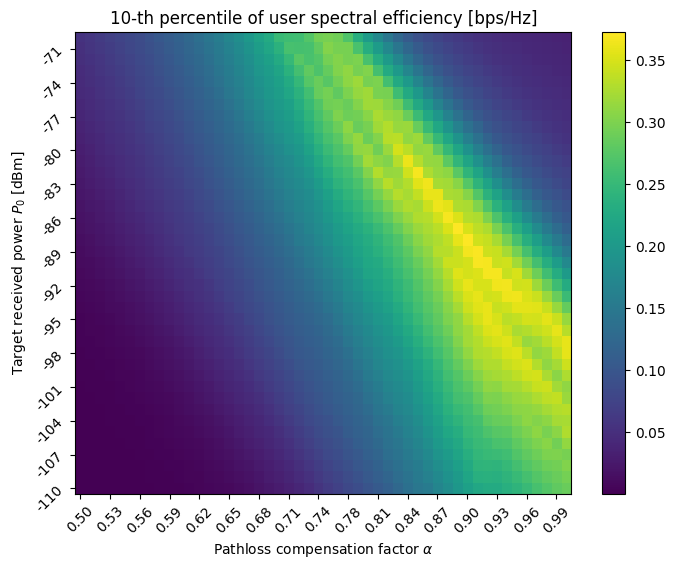

In [14]:
xth_percentile = 10
metric_mat = np.zeros([len(p0_dbm_vec), len(alpha_vec)])

for idx_p0, p0_dbm in enumerate(p0_dbm_vec):
    for idx_alpha, alpha in enumerate(alpha_vec):
        metric_mat[idx_p0, idx_alpha] = np.nanpercentile(
            se_per_ut_ul_mat[idx_p0, idx_alpha, :], xth_percentile)

plt.figure(figsize=(8, 6))
plt.imshow(metric_mat, aspect='auto')
plt.colorbar()
plt.ylabel(r'Target received power $P_0$ [dBm]')
plt.xlabel(r'Pathloss compensation factor $\alpha$')
plt.title(f'{xth_percentile}-th percentile of user spectral efficiency [bps/Hz]')
plt.yticks(np.arange(len(p0_dbm_vec)), p0_dbm_vec)
plt.gca().invert_yaxis()
show_every = 3
plt.xticks(np.arange(0, len(alpha_vec), show_every), 
           [f'{alpha_vec[i]:.2f}' for i in range(0, len(alpha_vec), show_every)], rotation=45)
plt.yticks(np.arange(0, len(p0_dbm_vec), show_every), 
           [p0_dbm_vec[i] for i in range(0, len(p0_dbm_vec), show_every)], rotation=45)
plt.show()

The result above arises from the fact that increasing either $\alpha$ or $P_0$
raises the intended received power at the base station, but also amplifies the
interference to neighboring cells.  
Hence, a trade-off between these two
parameters is necessary to optimize system performance.

It is also interesting to evaluate the distribution of the power allocation
across users.

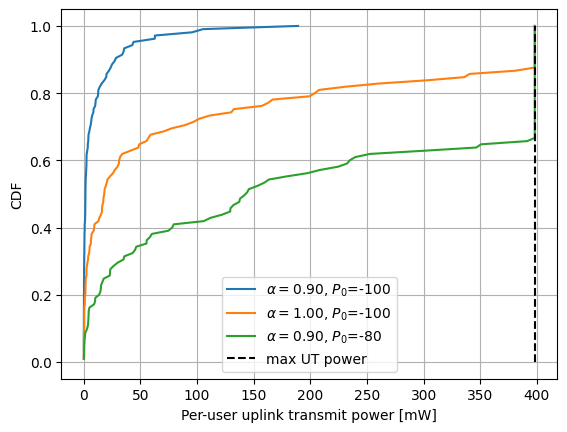

In [15]:
def get_cdf(values):
    """
    Computes the Cumulative Distribution Function (CDF) of the input
    """
    values = np.array(values).flatten()
    n = len(values)
    sorted_val = np.sort(values)
    cumulative_prob = np.arange(1, n+1) / n
    return sorted_val, cumulative_prob

alpha_po_vec = [(.9, -100), (1., -100), (.9, -80)]

fig, ax = plt.subplots()
for alpha, po in alpha_po_vec:
    idx_p0, idx_alpha = np.argmin(np.abs(p0_dbm_vec - po)), np.argmin(np.abs(alpha_vec - alpha))
    ax.plot(*get_cdf(ul_power_mat[idx_p0, idx_alpha, :]*1e3), 
            label=fr'$\alpha=${alpha_vec[idx_alpha]:.2f}, $P_0$={p0_dbm_vec[idx_p0]}')

ax.plot([dbm_to_watt(ut_max_power_dbm)*1e3]*2, [0, 1], 'k--', label='max UT power')
ax.set_xlabel('Per-user uplink transmit power [mW]')
ax.set_ylabel('CDF')
ax.legend()
ax.grid()
plt.show()

As expected, an increase of either the pathloss compensation factor $\alpha$ or the target received
power $P_0$ leads to a higher power allocation, which eventually saturates at
the maximum transmit power for the user terminal.

## Downlink power control

In the downlink, the base station distributes the per-resource transmit power
$p_u$ across different users $u=1,\dots,P$.

The function [downlink_fair_power_control](../api/power_control.html#sionna.sys.downlink_fair_power_control) maximizes a fairness
function $g^{(f)}$ defined as in [[2]](#references) of the maximum attainable throughput:
$$
\mathbf{p}^* = \operatorname{argmax}_{\mathbf{p}} \, \sum_{u=1}^{U} g^{(f)}
\big( r_u \log( 1 + p_u q_u) \big)
$$

where $q_u$ is a measure of the channel quality for user $u$ and $r_u$ is the
number of allocated resources for $u$.

The base station transmit power must not exceed $P^{\mathrm{max}}_{\mathrm{bs}}$:
$$
\sum_{u=1}^U r_u p_u = P^{\mathrm{max}}_{\mathrm{bs}}
$$

Moreover, to ensure that all scheduled users obtain a positive throughput, we can impose a lower bound on the individual allocated powers:
$$
r_u p_u \ge \rho \frac{P^{\mathrm{max}}_{\mathrm{bs}}}{U} , \quad \forall \, u=1,\dots,U
$$
where $0\le \rho \le 1$. Note that if $\rho=1$, then all users obtain the same
power allocation.

To estimate the channel quality for each user, we compute the pathloss from the
serving cell and the interference from all neighboring cells.

In [16]:
# Pathloss
# [batch_size, num_ut, num_bs, num_ofdm_symbols], [batch_size, num_ut, num_ofdm_symbols]
pathloss_all_pairs, pathloss_serving_cell = get_pathloss(
    h_freq_dl,
    rx_tx_association=tf.cast(rx_tx_association_dl, dtype=tf.int32))

# Interference from all base stations
# [batch_size, num_ut, num_ofdm_symbols]
one = tf.cast(1, pathloss_serving_cell.dtype)
interference_dl = tf.reduce_sum(
    one / pathloss_all_pairs, axis=-2) - one / pathloss_serving_cell
interference_dl *= bs_max_power

# Group by base station
# [batch_size, num_bs, num_ut_per_sector, num_ofdm_sym]
pathloss_serving_cell = group_by_bs(pathloss_serving_cell)
interference_dl = group_by_bs(interference_dl)

### Impact of parameters on system performance

The downlink power allocation procedure in [downlink_fair_power_control](../api/power_control.html#sionna.sys.downlink_fair_power_control)
is governed by two parameters:
- the fairness parameter $f$, defined as in [[2]](#references).  
  If $f=0$, then the sum of throughput is
  maximized, favoring users with good channel conditions while potentially
  leaving those in poor conditions without power.  
  As $f$ increases, the allocation becomes more egalitarian across users;
- the guaranteed power ratio $\rho$, which defines the minimum power allocation
  per user.

To evaluate the impact of these two design parameters on the network performance, we
evaluate the spectral efficiency distribution as $(f,\rho)$ vary.

In [17]:
def get_sinr_downlink(guaranteed_power_ratio,
                      fairness_dl):
    """ Compute the downlink SINR """
    # [batch_size, num_bs, num_ofdm_symbols, num_ut_per_sector]
    dl_power_per_ut, _ = downlink_fair_power_control(
        pathloss_serving_cell,
        interference_dl + no,
        num_allocated_subcarriers,
        bs_max_power_dbm=bs_max_power_dbm,
        guaranteed_power_ratio=guaranteed_power_ratio,
        fairness=fairness_dl)

    # Spread power uniformly across subcarriers
    # [batch_size, num_bs, num_ut_per_sector, num_streams_per_ut, num_ofdm_sym, num_subcarriers]
    dl_power = spread_across_subcarriers(
        dl_power_per_ut,
        is_scheduled,
        num_tx=1)

    dl_power = tf.reshape(dl_power,
                          [batch_size, num_bs, num_streams_per_bs,
                           num_ofdm_sym, num_subcarriers])

    precoded_channel = RZFPrecodedChannel(resource_grid=resource_grid,
                                          stream_management=stream_management_dl)
    h_eff = precoded_channel(h_freq_dl, tx_power=dl_power, alpha=no)

    lmmse_posteq_sinr = LMMSEPostEqualizationSINR(resource_grid=resource_grid,
                                                  stream_management=stream_management_dl)

    # [batch_size, num_ofdm_symbols, num_subcarriers, num_ut, num_streams_per_ut]
    sinr = lmmse_posteq_sinr(h_eff, no=no, interference_whitening=True)
    return sinr, dl_power_per_ut

In [18]:
# Fairness parameters to evaluate
fairness_dl_vec = [0, .5, 1]

# Guaranteed power ratio to evaluate
guaranteed_power_ratio_vec = [0, .3]

# Per-user spectral efficiency per user across (fairness, guaranteed power ratio) values
se_per_ut_dl_mat = np.zeros([len(fairness_dl_vec),
                             len(guaranteed_power_ratio_vec), num_ut*batch_size])
dl_power_mat = np.zeros([len(fairness_dl_vec),
                                len(guaranteed_power_ratio_vec), num_ut*batch_size])

# Compute the spectral efficiency for each (fairness, guaranteed power ratio) pair
for idx_guar, guaranteed_power_ratio in enumerate(guaranteed_power_ratio_vec):
    for idx_fair, fairness_dl in enumerate(fairness_dl_vec):

        # Compute SINR and DL power distribution
        sinr, dl_power_per_ut = get_sinr_downlink(guaranteed_power_ratio, fairness_dl)

        # Spectral efficiency
        se_per_ut_dl_mat[idx_fair, idx_guar, :] = get_se(sinr).numpy().flatten()
        # Power allocation
        dl_power_mat[idx_fair, idx_guar, :] = dl_power_per_ut.numpy().mean(axis=2).flatten()

Finally, we visualize the spectral efficiency distribution across the different
values of fairness $f$ and guaranteed power ratio $\rho$.

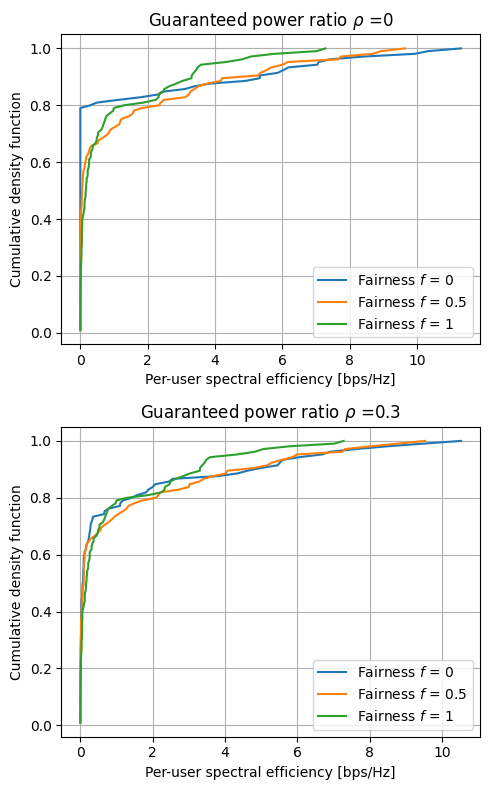

In [19]:
fig, axs = plt.subplots(len(guaranteed_power_ratio_vec),
                        figsize=(5, 4*len(guaranteed_power_ratio_vec)))

for idx_guar, guaranteed_power_ratio in enumerate(guaranteed_power_ratio_vec):
    axs[idx_guar].set_title(r'Guaranteed power ratio $\rho$ =' + f'{guaranteed_power_ratio}')
    for idx_fair, fairness_dl in enumerate(fairness_dl_vec):
        axs[idx_guar].plot(*get_cdf(se_per_ut_dl_mat[idx_fair, idx_guar, :]), label=f'Fairness $f$ = {fairness_dl}')
    
for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel('Per-user spectral efficiency [bps/Hz]')
    ax.set_ylabel('Cumulative density function')
fig.tight_layout()

plt.show()

The figure above shows that, as fairness $f$ increases, the spectral efficiency
distribution tends to become more balanced, with fewer users receiving poor
service but also fewer achieving high throughput.  
It also demonstrates that by increasing the value of guaranteed power
ratio $\rho$ one can achieve a similar effect as by increasing $f$.

It is also interesting to evaluate the power allocation distribution for
different values of fairness $f$ and guaranteed power ratio $\rho$.

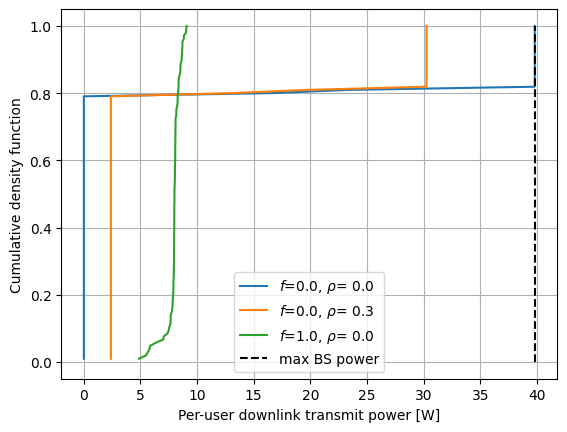

In [20]:
fairness_guar_ratio_vec = [(0, 0), (0, .5), (1, 0)]

fig, ax = plt.subplots()
for fairness, guaranteed_power_ratio in fairness_guar_ratio_vec:
    idx_fair = np.argmin(np.abs(np.array(fairness_dl_vec) - fairness))
    idx_guar = np.argmin(np.abs(np.array(guaranteed_power_ratio_vec) - guaranteed_power_ratio))
    ax.plot(*get_cdf(dl_power_mat[idx_fair, idx_guar, :]), 
            label=fr'$f$={fairness_dl_vec[idx_fair]:.1f}, $\rho$= {guaranteed_power_ratio_vec[idx_guar]:.1f}')

ax.plot([dbm_to_watt(bs_max_power_dbm)]*2, [0, 1], 'k--', label='max BS power')
ax.set_xlabel('Per-user downlink transmit power [W]')
ax.set_ylabel('Cumulative density function')
ax.legend()
ax.grid()
plt.show()

We observe that setting the fairness parameter $f=1$ results in a a roughly uniform power
distribution.  
In contrast, when $f=0$, power is only allocated to users with good
channel conditions, leaving most users with no power at
all. However, increasing the guaranteed power ratio $\rho$ helps mitigate this effect.

For computational efficiency, we recommend setting $f=0$ and
choosing $\rho >0$ to ensure that all users receive some power
allocation.

## Conclusions

Power allocation in both uplink and downlink requires a global perspective on the network to ensure fairness across all served users.

We provide two built-in functions for this purpose:

- [open_loop_uplink_power_control](https://nvlabs.github.io/sionna/sys/api/power_control.html#sionna.sys.open_loop_uplink_power_control)
  for uplink power allocation following the open-loop procedure described in 3GPP TS 38.213 [[1]](#references)
- [downlink_fair_power_control](https://nvlabs.github.io/sionna/sys/api/power_control.html#sionna.sys.downlink_fair_power_control)
  for fair downlink power allocation.

Note that power control is closely tied to scheduling: once users are assigned
to resource elements and streams, the transmission power is determined
accordingly.   
For more
details on scheduling, refer to the [Proportional
Fairness Scheduler
notebook](https://nvlabs.github.io/sionna/sys/tutorials/Scheduling.html).
The
[System-Level Simulations
notebook](https://nvlabs.github.io/sionna/sys/tutorials/End-to-End_Example.html)
further illustrates how scheduling and power control interact.

## References
[1] 3GPP TS 38.213. "NR; Physical layer procedures for control"  
[2] J. Mo, J. Walrand. *Fair end-to-end window-based congestion control*. IEEE/ACM Transactions on networking 8.5 (2000): 556-567.